# Image Prompt

In [1]:
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

/home/llt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ONLY GOOD PROMPTS HERE
example_prompts = rp.load_yaml_file('source/example_prompts.yaml')
print('Available example prompts:', ', '.join(example_prompts))

#These prompts are all strings - you can replace them with whatever you want! By default it lets you choose from example prompts
#Here are some on the site! It does take some thought to come up with good ideas; the upside-down should look vaguely like the right-side up to work nicely
prompt_a = rp.gather(example_prompts, 'vegetable'.split())
# prompt_a, prompt_b = rp.gather(example_prompts, 'sailing_ship sailing_ship'.split())

negative_prompt = ''

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up

Available example prompts: kitten_in_box, botw_landscape, magic_emma_watson, yorkshire_terrier_santa, norwegian_winter_girl, magic_forest_temple, sailing_ship, bioshock_lighthouse, two_bunnys_hugging, thomas_tank_military, wolf_on_rock, victorial_dress, lolita_dress_magical_elf, pencil_giraffe_head, pencil_penguin, pencil_violin, pencil_orca_whale, pencil_cow, pencil_walrus, pencil_cat_head, pencil_dog_head, ape_with_gun, human_skeleton, gold_coins, golf_ball_in_forest, bear_in_forest, elephant_in_circus, mickey_mouse, mushroom, mario, burger, darth_vader, gandalf, fantasy_city, green_elf_girl, pikachu, spring, fall, winter, summer, miku, pyramids, dinosaur, lipstick, picard, bull_wing, froggo, assasin_creed, moon, minecraft_zombie, pistol, disco_ball, volcano, porche, hawaii_beach, walter_white, dalek, tardis, tennant, weeping_angel, vegetable

Negative prompt: ''

Chosen prompts:
    prompt_a = ['many vegetable, oil painting, octane render']


# New Section

In [3]:
!export HF_ENDPOINT=https://hf-mirror.com

In [4]:
if 's' not in dir():
    model_name="./stable-diffusion-v1-4"
    gpu='cuda:0'
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

[INFO] sd.py: loading stable diffusion...please make sure you have run `huggingface-cli login`.


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 12.32it/s]


[INFO] sd.py: loaded stable diffusion!


In [5]:
from PIL import Image
import torch
from torchvision import transforms

# 1. 从文件中读取图像
image_path = "your_image.png"  # 替换为你的图像路径
image = Image.open(image_path)
if image.mode == 'RGBA':
    image = image.convert('RGB')  

# 2. 定义预处理步骤
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整大小为 256x256
    transforms.ToTensor(),  # 转换为 PyTorch 张量
])

# 3. 对图像进行预处理
image_tensor = preprocess(image)

In [6]:
label_a = NegativeLabel(prompt_a,negative_prompt)

In [7]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256, width=256, hidden_dim=256, num_features=128).to(s.device); SIZE=256
# learnable_image_maker = lambda: LearnableImageFourier(height=512,width=512,num_features=256,hidden_dim=256,scale=20).to(s.device);SIZE=512

image=learnable_image_maker()

In [8]:
learnable_image_a=lambda: image() #Right-side up

optim=torch.optim.SGD(image.parameters(),lr=1e-4)

In [9]:
labels=[label_a]
learnable_images=[learnable_image_a]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [10]:
#For saving a timelapse
ims=[]

In [11]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

In [12]:
print(image_tensor.shape)

torch.Size([3, 256, 256])


Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


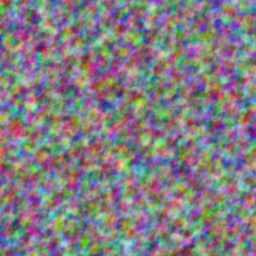

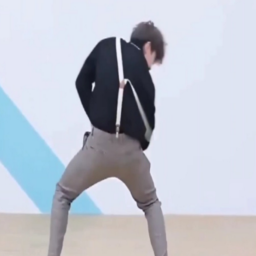

Status: ETR=0:31:22.675367	ETA=0:32:00.901303	T=0:00:38.225936	Progress: 199/10000

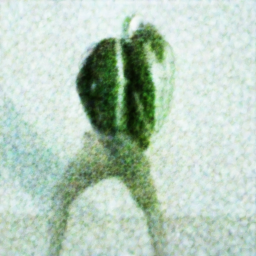

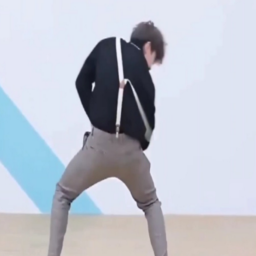

Status: ETR=0:30:33.555471	ETA=0:31:49.754683	T=0:01:16.199212	Progress: 399/10000

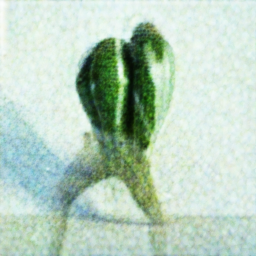

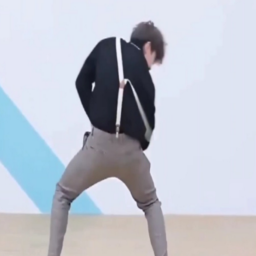

Status: ETR=0:29:45.899470	ETA=0:31:39.690958	T=0:01:53.791488	Progress: 599/10000

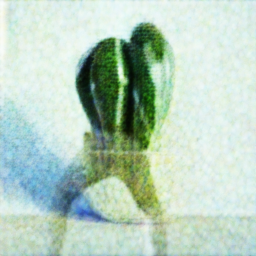

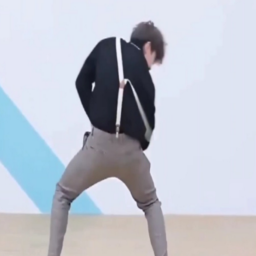

Status: ETR=0:28:58.823561	ETA=0:31:29.820194	T=0:02:30.996634	Progress: 799/10000

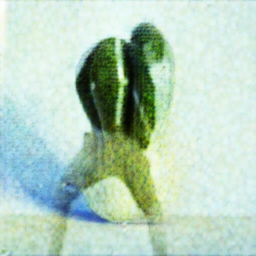

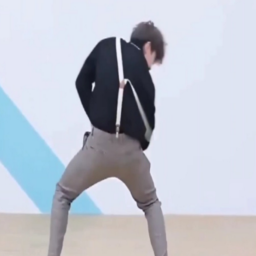

Status: ETR=0:28:23.831807	ETA=0:31:25.395382	T=0:03:01.563575	Progress: 963/10000
Interrupted early at iteration 963


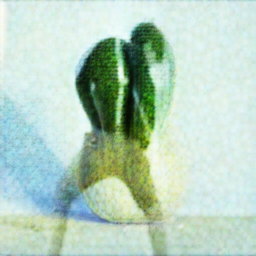

In [13]:
NUM_ITER=10000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=60,target_image=image_tensor
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%DISPLAY_INTERVAL:
                im = get_display_image()
                ims.append(im)
                rp.display_image(im)
                rp.display_image(image_tensor)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

hybird image


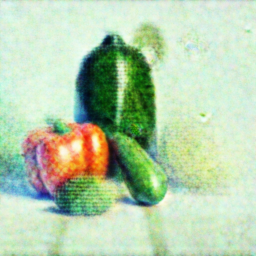

In [28]:
print('hybird image')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

In [30]:
def save_run(name):
    folder="untracked/flippy_illusion_runs/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))
    
save_run('o/w_STFT') #You can give it a good custom name if you want!

rp.save_images: Done! Saved 7 images in 0.054 seconds

Saved timelapse to folder: 'untracked/flippy_illusion_runs/o/STFT'
